#### This kernel is in-process prototype model which builds for kaggle competitions "Understanding cloud organization". Reach out 0.647 in LB, use light-ResNet101 + Unet model base on Tensorflow, with post process include mask threshold, drop small mask and reshape the predict mask to rectangle shape.

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow import keras
from sklearn.model_selection import train_test_split

#seems pre-trained resnet50-Unet reach memory limitations, so use handmade downscale resnet50.
from mini_res50unet_v2 import unet

from skimage.exposure import adjust_gamma
import albumentations as albu

### Read Data

In [2]:
base_path = '/input/understanding_cloud_organization/'
train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))
train_df['Image'] = train_df['Image_Label'].apply(lambda x: x.split('_')[0])
train_df['Label'] = train_df['Image_Label'].apply(lambda x: x.split('_')[1])
train_df['has_mask'] = ~train_df['EncodedPixels'].isna()
print(train_df.shape)
train_df.head()

(22184, 5)


,Image_Label,EncodedPixels,Image,Label,has_mask
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,True
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,True
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel,False
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar,False
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,True


In [3]:
mask_count_df = train_df.groupby('Image').agg(np.sum).reset_index()
print(mask_count_df.shape)
mask_count_df.head()

(5546, 2)


,Image,has_mask
0,0011165.jpg,2.0
1,002be4f.jpg,3.0
2,0031ae9.jpg,3.0
3,0035239.jpg,2.0
4,003994e.jpg,3.0


In [4]:
def post_process(mask, threshold, min_size, input_size=(350, 525), image=None, rectangle=False):
    new_mask = np.zeros(input_size, dtype='uint8')
    blk_mask = np.empty(input_size, dtype='uint8')
    mask = cv2.threshold(mask, threshold, 1, cv2.THRESH_BINARY)[1]
    
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))

    predictions = np.zeros(input_size, np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            if rectangle:
                new_mask = rectangle_process(image, new_mask, p)
            predictions[p] = 1
            num += 1
    return predictions, new_mask, num

def rectangle_process(img, new_mask, block):
    cnts, _ = cv2.findContours(block.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(new_mask, (x, y), (x+w, y+h), 1, -1)
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        l = np.array([0, 0, 0])
        u = np.array([0, 0, 0])
        blk_mask = cv2.inRange(img, l, u)
        #new_mask = cv2.bitwise_or(new_mask, blk_mask)
        new_mask = cv2.subtract(new_mask, blk_mask)
        return new_mask

### Utility fuctions
Source: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

In [5]:
def np_resize(img, input_shape):
    height, width = input_shape
    return cv2.resize(img, (width, height))

def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def mask_maker(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

### EDA

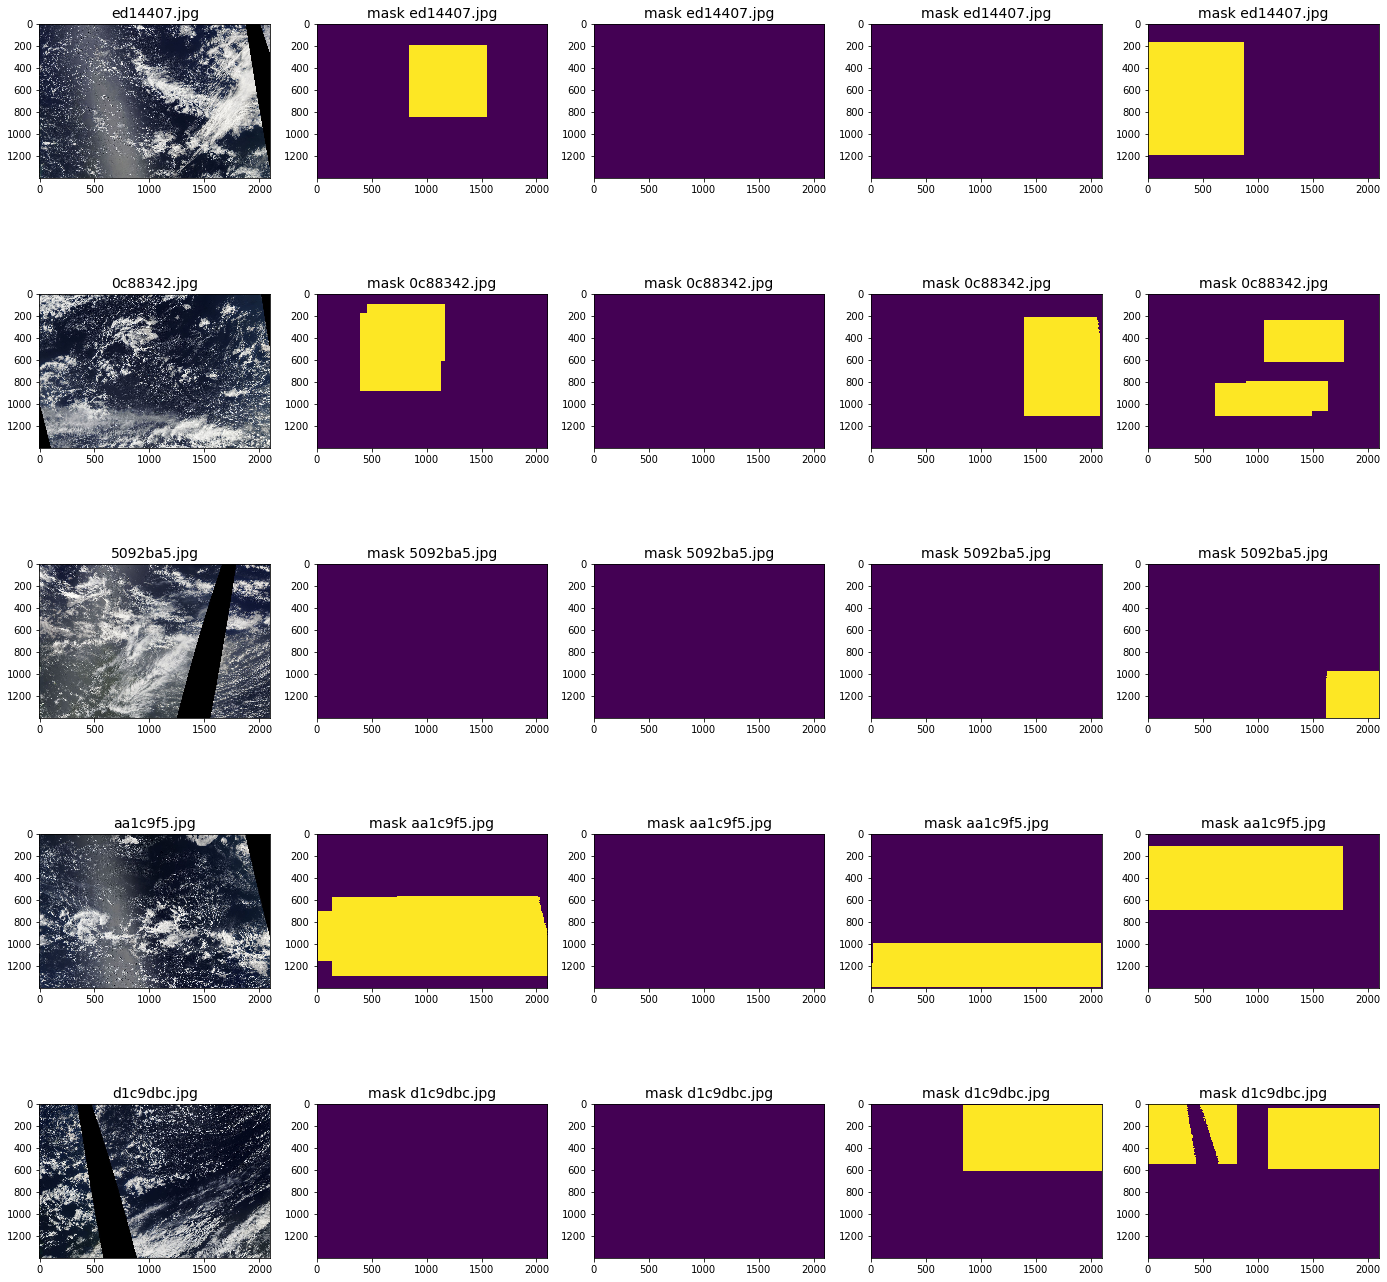

In [6]:
base_path='/input/understanding_cloud_organization/train_images'
img, ax =plt.subplots(5, 5, figsize=(24, 24))
for i, ID in enumerate(mask_count_df['Image'].sample(5)):
    image_path = f'{base_path}/{ID}'
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i, 0].imshow(img)
    ax[i, 0].set_title(ID, fontsize=14)
    mask_df = train_df[train_df['Image'] == ID]
    rles = mask_df['EncodedPixels']
    masks = mask_maker(rles, input_shape=(1400, 2100))
    for j in range(len(rles)):
        ax[i, j+1].imshow(masks[:,:,j])
        ax[i, j+1].set_title(f'mask {ID}', fontsize=14)
plt.show()

### Loss function
Source for bce_dice_loss: https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/

In [7]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

### Data Generator

In [8]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, df, target_df, batch_size, mode='fit',
                base_path='/input/understanding_cloud_organization/train_images',
                channels=3, classes=4, input_size=(1400, 2100) ,augment=False, gamma=None,
                reshape=None, random_state=2019, shuffle=True):
    
        self.list_IDs = list_IDs
        self.df = df
        self.target_df = target_df
        self.batch_size = batch_size
        self.mode = mode
        self.base_path = base_path
        self.channels = channels
        self.classes = classes
        self.input_size = input_size
        self.augment = augment
        self.reshape = reshape
        self.random_state = random_state
        self.shuffle = shuffle
        self.gamma = gamma

        self.on_epoch_end()
        np.random.seed(self.random_state)
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generator_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generator_y(list_IDs_batch)
            
            if self.augment:
                X, y = self.__batch_augment(X, y)
            
            return X, y
        
        elif self.mode == 'predict':
            return X
        
        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
            
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generator_X(self, list_IDs_batch):
        
        if self.reshape is not None:
            X = np.empty((self.batch_size, *self.reshape, self.channels))
        else:
            X = np.empty((self.batch_size, *self.input_size, self.channels))
        
        for i, ID in enumerate(list_IDs_batch):
            fn = self.df['Image'].iloc[ID]
            img_path = f'{self.base_path}/{fn}'
            img = self.__load_rgb(img_path)
            
            if self.reshape is not None:
                img = np_resize(img, self.reshape)
            if self.gamma is not None:
                img = adjust_gamma(img, gamma=self.gamma)
            
            X[i, ] = img
            
        return X
    
    def __generator_y(self, list_IDs_batch):
        
        if self.reshape is not None:
            y = np.empty((self.batch_size, *self.reshape, self.classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.input_size, self.classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            img = self.df['Image'].iloc[ID]
            img_df = self.target_df[self.target_df['Image'] == img]
            rles = img_df['EncodedPixels']
            
            if self.reshape is None:
                mask = mask_maker(rles, input_shape=self.input_size)
            else:
                mask = mask_maker(rles, input_shape=self.input_size, reshape=self.reshape)
                        
            y[i, ] = mask
            
        return y
            
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.
        return img
    
    def __random_transform(self, img, masks):
        composition = albu.Compose([
            albu.HorizontalFlip(),
            albu.VerticalFlip(),
            albu.ShiftScaleRotate(shift_limit=0.1, rotate_limit=30),
            #albu.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
        ])
        
        composed = composition(image=img, mask=masks)
        aug_img = composed['image']
        aug_mask = composed['mask']
        return aug_img, aug_mask
    
    def __batch_augment(self, img_batch, mask_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i,], mask_batch[i, ] = self.__random_transform(img_batch[i, ], mask_batch[i, ]) 
        return img_batch, mask_batch
    
    def get_labels(self):
        if self.shuffle:
            images_current = self.images_list[:self.len*self.batch_size]
            labels = [img_2_ohe_vector[img] for img in images_current]
        else:
            labels = self.labels
        return np.array(labels)

In [9]:
BATCH_SIZE = 8

train_idx, val_idx = train_test_split(mask_count_df.index, random_state=2019, test_size=0.2)

train_generator = DataGenerator(train_idx,
                                df=mask_count_df,
                                target_df=train_df,
                                batch_size=BATCH_SIZE,
                                augment=True,
                                gamma=0.8,
                                reshape=(320, 480)
                               )
val_generator = DataGenerator(val_idx,
                              df=mask_count_df,
                              target_df=train_df,
                              batch_size=BATCH_SIZE,
                              augment=False,
                              gamma=0.8,
                              reshape=(320, 480)
                             )

In [10]:
model = unet(
    input_shape=(320, 480, 3),
    encoder_filters=(16, 32, 64, 128),
    encoder_blocks=(3, 4, 23, 3),
    decoder_mode='upsampling',
    classes=4,
    n_upsampling_blocks=4,
    activation='sigmoid',
    decoder_use_batchnorm=True
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 480, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 320, 480, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 240, 16) 448         batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 160, 240, 16) 64          conv2d[0][0]                     
______________________________________________________________________________________________

In [11]:
#opt = AdamAccumulate(lr=0.002, accum_iters=8)
model.compile(optimizer=Adam(lr=0.0001),
              loss=bce_dice_loss,
              metrics=[dice_coef],
             )

In [16]:
checkpoint = ModelCheckpoint('model_res101_v2.h5', save_best_only=True)
earlystop = EarlyStopping(monitor='val_dice_coef', min_delta=0.0001, patience=5, verbose=1, mode='max',
                          restore_best_weights=True)
reduceLR = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, patience=2, verbose=1, mode='max',
                             min_delta=0.00001)

history = model.fit_generator(train_generator,
                        validation_data=val_generator,
                        callbacks=[checkpoint, earlystop, reduceLR],
                        epochs=30,
                       )

Epoch 1/30
554/554 [==============================] - 1211s 2s/step - loss: 1.0555 - dice_coef: 0.3409 - val_loss: 1.2105 - val_dice_coef: 0.4277
Epoch 2/30
554/554 [==============================] - 1192s 2s/step - loss: 0.9445 - dice_coef: 0.4159 - val_loss: 0.9565 - val_dice_coef: 0.4651
Epoch 3/30
554/554 [==============================] - 1142s 2s/step - loss: 0.9185 - dice_coef: 0.4344 - val_loss: 0.9512 - val_dice_coef: 0.4378
Epoch 4/30
554/554 [==============================] - 1228s 2s/step - loss: 0.8997 - dice_coef: 0.4479 - val_loss: 0.8505 - val_dice_coef: 0.4951
Epoch 5/30
554/554 [==============================] - 1186s 2s/step - loss: 0.8863 - dice_coef: 0.4565 - val_loss: 0.8805 - val_dice_coef: 0.4845
Epoch 6/30
553/554 [============================>.] - ETA: 1s - loss: 0.8797 - dice_coef: 0.4615
Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
554/554 [==============================] - 1221s 2s/step - loss: 0.8802 - dice_coef: 0.4615 -

<Figure size 1440x1008 with 0 Axes>

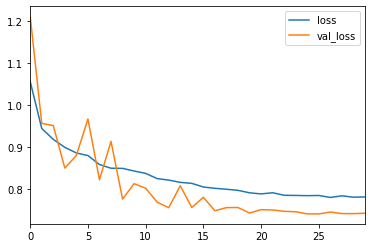

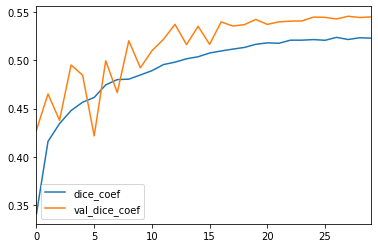

In [17]:
plt.figure(figsize=(20, 14))
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

### Visualization Post-Process

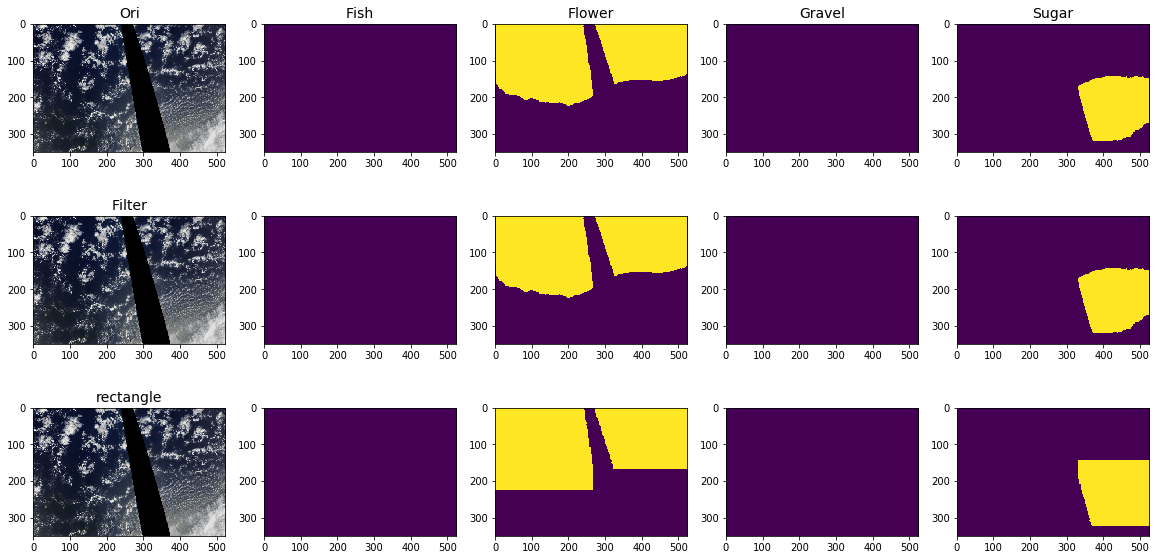

In [21]:
cate_label = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
process = {0: 'Ori', 1: 'Filter', 2: 'rectangle'}
base_path = '/input/understanding_cloud_organization/test_images'
img, ax = plt.subplots(3, 5, figsize=(20, 10))
for i, ID in enumerate(pre_df['Image'].sample(1)):
    img_path = f'{base_path}/{ID}'
    img = cv2.imread(img_path)
    img = cv2.resize(img, (525, 350))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for r in range(3):
        ax[r, 0].imshow(img)
        ax[r, 0].set_title(process[r], fontsize=14)
    mask_df = test_df[pre_df['Image'] == ID]
    rles = mask_df['EncodedPixels']
    masks = mask_maker(rles, (350, 525))
    for j in range(len(rles)):
        ax[0, j+1].imshow(masks[:, :, j])
        ax[0, j+1].set_title(cate_label[j], fontsize=14)
        post_mask, new_mask, num = post_process(masks[:, :, j], 0, 10000, image=img, rectangle=True)
        ax[1, j+1].imshow(post_mask)
        ax[2, j+1].imshow(new_mask)

plt.show()

### Post-Process parameter optimization

In [22]:
model.load_weights('model_res101_v2.h5')

optimal_generator = DataGenerator(val_idx,
                          df=mask_count_df,
                          target_df=train_df,
                          batch_size=1,
                          mode='predict',
                          shuffle=False,
                          augment=False,
                          gamma=0.8,
                          reshape=(320, 480)
                         )

val_pred_masks = model.predict_generator(
    optimal_generator,
    workers=1,
    verbose=1
)


1110/1110 [==============================] - 155s 139ms/step


1096 4264


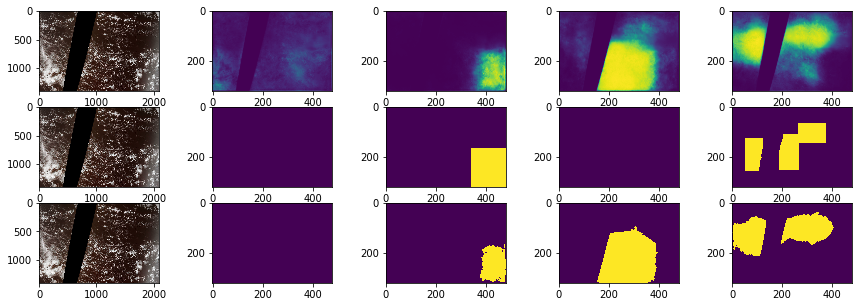

In [23]:
s = np.random.choice(len(val_idx))
print(s, val_idx[s])
img, ax = plt.subplots(3, 5, figsize=(15, 5))
path = '/input/understanding_cloud_organization/train_images/'
fn = mask_count_df['Image'].iloc[val_idx[s]]
img = cv2.imread(f'{path}/{fn}')
ax[0, 0].imshow(img)
ax[1, 0].imshow(img)
ax[2, 0].imshow(img)
rles_df = train_df[train_df['Image'] == mask_count_df['Image'].iloc[val_idx[s]]]
rles = rles_df['EncodedPixels']
true_y = np.empty((320, 480, 4))
true_y = mask_maker(rles, input_shape=(1400, 2100), reshape=(320, 480))
for i in range(4):
    ax[0, i+1].imshow(val_pred_masks[s,:,:,i])
    ax[1, i+1].imshow(true_y[:,:,i])
    post, _, _ = post_process(val_pred_masks[s,:,:,i], 0.5, 1000, input_size=(320, 480))
    ax[2, i+1].imshow(post)

In [24]:
val_dice = []
cate_label = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}

def val_dice_coef(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

In [25]:
from tqdm import tqdm

img = np.empty((len(val_idx), 320, 480, 3))
true_y = np.empty((len(val_idx),320, 480, 4))
#Generator img and true masks
for i in tqdm(range(len(val_idx))):           
    fn = mask_count_df['Image'].iloc[val_idx[i]]
    img_path = '/input/understanding_cloud_organization/train_images/' + fn
    image = cv2.imread(img_path)
    img[i, ] = np_resize(image, (320, 480))
    
    rles_df = train_df[train_df['Image'] == fn]
    rles = rles_df['EncodedPixels']
    true_y[i, ] = mask_maker(rles, input_shape=(1400, 2100), reshape=(320, 480))

100%|███████████████████████████████████████████████████████████████████████████████████| 1110/1110 [04:09<00:00,  6.31it/s]


In [26]:
for c in range(4):
    for t in range(20, 100, 5):
        t = t/100
        for mi in [5000, 10000, 15000, 20000]:
            pred_y = np.empty((320, 480))
            coef = []
            for i in range(len(val_idx)):           
                fn = mask_count_df['Image'].iloc[val_idx[i]]
                _, pred_y, _ = post_process(val_pred_masks[i,:,:,c], threshold=t,
                                            min_size=mi, input_size=(320, 480),
                                            image=img[i, ], rectangle=True)              
                coef.append(val_dice_coef(true_y[i, :, :, c], pred_y))
            coef = np.mean(coef)
            val_dice.append([t, mi, coef, cate_label[c]])
            print('{}, {}, {}, ceof = {}'.format(c, t, mi, coef))

0, 0.2, 5000, ceof = 0.5258583403671471
0, 0.2, 10000, ceof = 0.5440416233820103
0, 0.2, 15000, ceof = 0.5647638059462466
0, 0.2, 20000, ceof = 0.5703548549435467
0, 0.25, 5000, ceof = 0.5394085865658854
0, 0.25, 10000, ceof = 0.5652502411364567
0, 0.25, 15000, ceof = 0.5772545103026648
0, 0.25, 20000, ceof = 0.5809918466771427
0, 0.3, 5000, ceof = 0.5504940416029103
0, 0.3, 10000, ceof = 0.5738958632983083
0, 0.3, 15000, ceof = 0.5804216114239421
0, 0.3, 20000, ceof = 0.5923051516706547
0, 0.35, 5000, ceof = 0.5621665833761541
0, 0.35, 10000, ceof = 0.581019308433383
0, 0.35, 15000, ceof = 0.5887088985989712
0, 0.35, 20000, ceof = 0.6034561999036863
0, 0.4, 5000, ceof = 0.5713319669079989
0, 0.4, 10000, ceof = 0.5846545780513083
0, 0.4, 15000, ceof = 0.5941241292164733
0, 0.4, 20000, ceof = 0.6035191898851264
0, 0.45, 5000, ceof = 0.5783623273418261
0, 0.45, 10000, ceof = 0.5921081888918404
0, 0.45, 15000, ceof = 0.6020588469450554
0, 0.45, 20000, ceof = 0.6013238083784369
0, 0.5, 500

In [28]:
opt_df = pd.DataFrame(val_dice, columns=['threshold', 'min_size', 'dice_coef', 'cate'])
opt_df.to_csv('parameter_optimal_resnet101_v2.csv', index=False)

for i in range(4):
    print(opt_df[opt_df['cate'] == cate_label[i]].sort_values(by='dice_coef', ascending=False).head())

    threshold  min_size  dice_coef  cate
49       0.80     10000   0.615918  Fish
42       0.70     15000   0.613791  Fish
46       0.75     15000   0.612296  Fish
47       0.75     20000   0.612031  Fish
35       0.60     20000   0.611965  Fish
     threshold  min_size  dice_coef    cate
105       0.70     10000   0.767412  Flower
98        0.60     15000   0.766539  Flower
109       0.75     10000   0.766420  Flower
112       0.80      5000   0.766327  Flower
106       0.70     15000   0.765725  Flower
     threshold  min_size  dice_coef    cate
165       0.65     10000   0.614665  Gravel
163       0.60     20000   0.613751  Gravel
169       0.70     10000   0.613675  Gravel
162       0.60     15000   0.613373  Gravel
170       0.70     15000   0.613255  Gravel
     threshold  min_size  dice_coef   cate
232       0.70      5000   0.587964  Sugar
221       0.55     10000   0.587889  Sugar
217       0.50     10000   0.586188  Sugar
228       0.65      5000   0.585389  Sugar
225       0

### submission

In [12]:
sub_df = pd.read_csv('/input/understanding_cloud_organization/sample_submission.csv')
sub_df['Image'] = sub_df['Image_Label'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['Image'].unique(), columns=['Image'])

In [13]:
model.load_weights('model_res101_v2.h5')
BASE_PATH='/input/understanding_cloud_organization/test_images'
test_df = []

for i in range(0, test_imgs.shape[0], 500):
    batch_idx = list(
        range(i, min(test_imgs.shape[0], i + 500))
    )

    test_generator = DataGenerator(
        batch_idx,
        df=test_imgs,
        shuffle=False,
        mode='predict',
        input_size=(350, 525),
        reshape=(320, 480),
        gamma=0.8,
        channels=3,
        base_path=BASE_PATH,
        target_df=sub_df,
        batch_size=1,
        classes=4
    )

    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=0
    )

    thresholds = [0.8, 0.7, 0.65, 0.7]
    minsizes = [10000, 10000, 10000, 5000]
    for j, b in enumerate(batch_idx):
        filename = test_imgs['Image'].iloc[b]
        image_df = sub_df[sub_df['Image'] == filename].copy()

#       pred_masks = batch_pred_masks[j, ].round().astype(int)
        img = cv2.imread(f'{BASE_PATH}/{filename}')
        img = np_resize(img, (320, 480))
        pred_masks = np.empty((320, 480, 4))
        for n in range(4):     
            _, pred_mask, _ = post_process(batch_pred_masks[j,:,:,n] , threshold=thresholds[n],
                                           min_size=minsizes[n],
                                           input_size=(320, 480), image=img, rectangle=True)
            pred_masks[:,:,n] = pred_mask                                                             
        
        pred_rles = build_rles(pred_masks, reshape=(350, 525))

        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)

In [14]:
test_df = pd.concat(test_df)
pre_df = test_df.copy()
test_df.drop(columns='Image', inplace=True)
test_df.to_csv('flower_submission_v18.csv', index=False)